# Preparatory Work and Data Analysis

### 1)

### 2)

In [1]:
import numpy as np
import random

mu_1 = np.array([-3, 0])
mu_2 = np.array([3, 0])
sigma_1 = np.array([[5, -2], [-2, 1]])
sigma_2 = np.array([[5, 2], [2, 2]])

X = []
Y = []

# generate data of the desired distribution
for i in range(0,500):
    r = random.uniform(0, 1)
    if r < 0.3:
        x, y = np.random.multivariate_normal(mu_1, sigma_1)
    else:
        x, y = np.random.multivariate_normal(mu_2, sigma_2)
    X.append(x)
    Y.append(y)


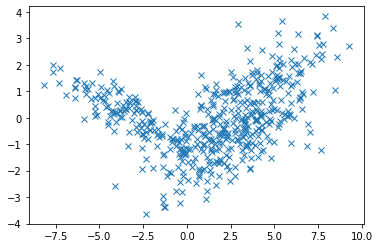

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(X, Y, 'x')
plt.show()

### 3)

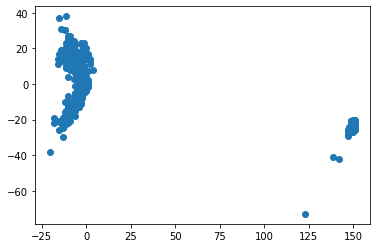

In [3]:
# reading the data and calculating the difference immediately

import pandas as pd

data = pd.read_csv('Unistroke/A01.txt', sep="\t", header=None).diff().iloc[1:]

for i in range(2,10):
    data = pd.concat([data, pd.read_csv('Unistroke/A0' + str(i) + '.txt', sep="\t", header=None).diff().iloc[1:]], ignore_index=True)
for i in range(10,51):
    data = pd.concat([data, pd.read_csv('Unistroke/A' + str(i) + '.txt', sep="\t", header=None).diff().iloc[1:]], ignore_index=True)

data.columns = ['x', 'y']
plt.scatter(data.x, data.y)

In [4]:
data2 = data.to_numpy()
data3 = np.copy(data2)

In [5]:
data

,x,y
0,150.0,-21.0
1,0.0,0.0
2,0.0,0.0
3,0.0,0.0
4,0.0,0.0
...,...,...
958,-4.0,7.0
959,-2.0,3.0
960,1.0,-1.0
961,0.0,0.0


In [6]:
# normalizing the data
from timeit import default_timer as timer
start = timer()
for i in range(len(data2)):
    x = data2[i][0]
    y = data2[i][1]
    if x != 0 or y != 0:
        mag = np.sqrt(x**2 + y**2)
        data2[i][0] = x / mag
        data2[i][1] = y / mag
end = timer()
print(end - start)


# removing vector zero
data2 = data2[~np.all(data2 == 0, axis=1)]
data2

0.0046558740000008925


array([[ 0.99034175, -0.13864784],
       [ 0.        , -1.        ],
       [-0.70710678, -0.70710678],
       ...,
       [-0.5547002 ,  0.83205029],
       [ 0.70710678, -0.70710678],
       [ 0.        ,  1.        ]])

In [7]:
# normalizing the data version 2.0
start = timer()
rr = data3 ** 2
test = np.divide(data3, np.sqrt(rr[:, 0] + rr[:, 1]).reshape(-1, 1), where=data3 != 0)
end = timer()

print(end - start)
# removing vector zero
test = test[~np.all(test == 0, axis=1)]
test

0.0005712650000013753


array([[ 0.99034175, -0.13864784],
       [ 0.        , -1.        ],
       [-0.70710678, -0.70710678],
       ...,
       [-0.5547002 ,  0.83205029],
       [ 0.70710678, -0.70710678],
       [ 0.        ,  1.        ]])

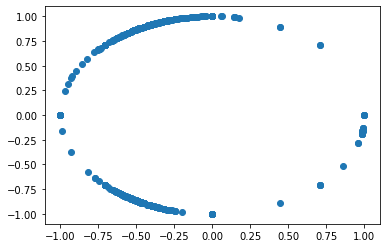

In [8]:
# plotting the normalized vectors

plt.scatter(data2[:,0], data2[:,1])

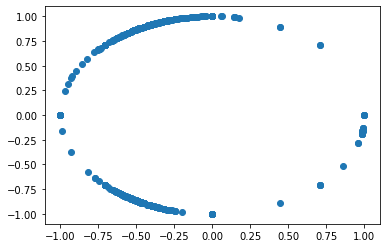

In [9]:
# plotting the normalized vectors version 2.0

plt.scatter(test[:,0], test[:,1])

In [10]:
from sklearn.mixture import GaussianMixture

model = GaussianMixture(n_components=2, n_init=10)

In [11]:
# fitting a two component GMM

y = model.fit_predict(data2)

In [12]:
print(model.n_iter_)
print(model.weights_)

print(model.converged_)

5
[0.47360602 0.52639398]
True


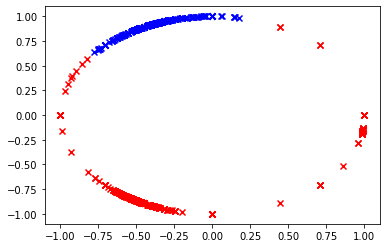

In [13]:
# splitting the data into different subgroups depending on the predicted class.
# Here the code works whether n_components = 2 or 3

x1 = []
y1 = []
x2 = []
y2 = []
x3 = []
y3 = []

for i in range(len(data2)):
    if y[i] == 0:
        x1.append(data2[i][0])
        y1.append(data2[i][1])
    elif y[i] == 1:
        x2.append(data2[i][0])
        y2.append(data2[i][1])
    else:
        x3.append(data2[i][0])
        y3.append(data2[i][1])
        
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(x1, y1, c='b', marker="x")
ax1.scatter(x2, y2, c='r', marker="x")
ax1.scatter(x3, y3, c='k', marker="x")


plt.show()

### Let's try some model selection
Reference: https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_selection.html#sphx-glr-auto-examples-mixture-plot-gmm-selection-py

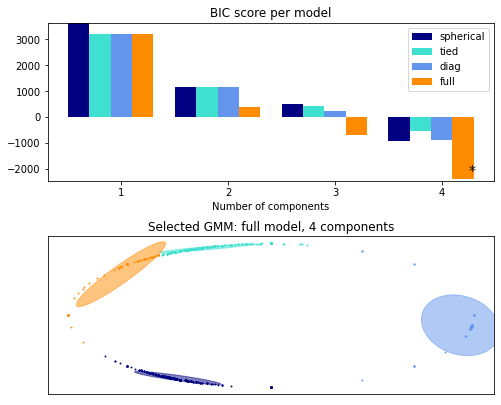

In [14]:
import itertools

from scipy import linalg
import matplotlib as mpl


X = np.copy(data2)

lowest_bic = np.infty
bic = []
n_components_range = range(1, 5)
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        gmm = GaussianMixture(n_components=n_components, covariance_type=cv_type, n_init=10)
        gmm.fit(X)
        bic.append(gmm.bic(X))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm
            best_cv = cv_type
            best_ncomponents = n_components

bic = np.array(bic)
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue', 'darkorange'])
clf = best_gmm
bars = []

# Plot the BIC scores
plt.figure(figsize=(8, 6))
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')
xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
    .2 * np.floor(bic.argmin() / len(n_components_range))
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)

# Plot the winner
splot = plt.subplot(2, 1, 2)
Y_ = clf.predict(X)
for i, (mean, cov, color) in enumerate(zip(clf.means_, clf.covariances_,
                                           color_iter)):
    v, w = linalg.eigh(cov)
    if not np.any(Y_ == i):
        continue
    plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)

    # Plot an ellipse to show the Gaussian component
    angle = np.arctan2(w[0][1], w[0][0])
    angle = 180. * angle / np.pi  # convert to degrees
    v = 2. * np.sqrt(2.) * np.sqrt(v)
    ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(.5)
    splot.add_artist(ell)

plt.xticks(())
plt.yticks(())
plt.title(f'Selected GMM: {best_cv} model, {best_ncomponents} components')
plt.subplots_adjust(hspace=.35, bottom=.02)
plt.show()

It appears covariance matrix of type full is the best choice for our data. I noticed that adding more components gives better(i.e. lower) BIC scores but they become negative. No idea if that's good or bad. Anyway, we continue with 2 components.

### 2)

/Users/david.emukpere/miniconda3/envs/pytorch-challenge/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Log scale: values of z <= 0 have been masked
/Users/david.emukpere/miniconda3/envs/pytorch-challenge/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


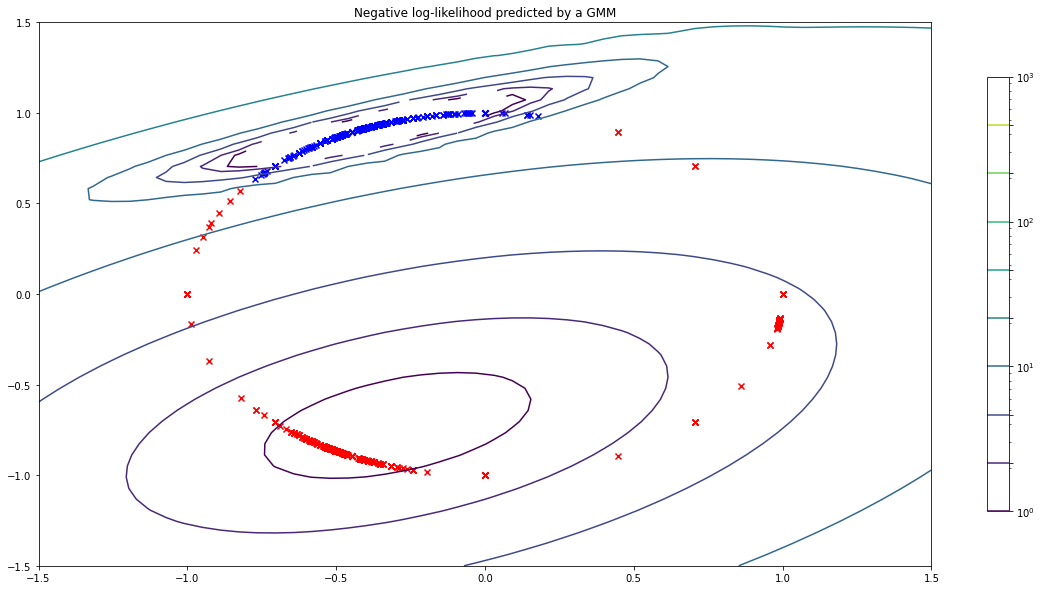

In [15]:
# plotting the contours of the log likelihood of the gmm

from matplotlib.colors import LogNorm
X_train = data2
clf = model

# display predicted scores by the model as a contour plot
x = np.linspace(-1.5, 1.5)
y = np.linspace(-1.5, 1.5)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = -clf.score_samples(XX)
Z = Z.reshape(X.shape)

fig, ax = plt.subplots(figsize=(20, 10))

CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                 levels=np.logspace(0, 3, 10))
CB = plt.colorbar(CS, shrink=0.8, extend='both')
ax.scatter(x1, y1, c='b', marker="x")
ax.scatter(x2, y2, c='r', marker="x")
ax.scatter(x3, y3, c='k', marker="x")
plt.title('Negative log-likelihood predicted by a GMM')
ax.axis('tight')
fig.show()

### 3)

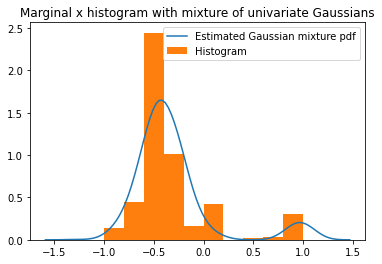

In [31]:
import seaborn as sns

all_x = []
all_y = []

for x_i , y_i in data2:
    all_x.append(x_i)
    all_y.append(y_i)

# fitting a univariate gmm on x-coordinates only
model_x = GaussianMixture(n_components=2, n_init=10, random_state=1)
model_x_pred = model_x.fit_predict(np.array(all_x).reshape(-1,1))
# extracting the parameters
weights_x = model_x.weights_.reshape(-1,)
mu_x = model_x.means_.reshape(-1,)
sigma_x = model_x.covariances_.reshape(-1,)
sdevs_x = np.sqrt(sigma_x)

samples_x = []
# generating random data according to the distribution to plot it
for i in range(0, 1000):
    if random.uniform(0, 1) < weights_x[0]:
        z = 0
    else:
        z = 1
    samples_x.append(np.random.normal(mu_x[z], sdevs_x[z], 1))

# plot the predicted distribution curve along with the histogram of the x-coordinates
sns.distplot(samples_x, hist=False, label='Estimated Gaussian mixture pdf')

plt.hist(all_x, density=True, label='Histogram')
plt.title('Marginal x histogram with mixture of univariate Gaussians')
plt.legend()

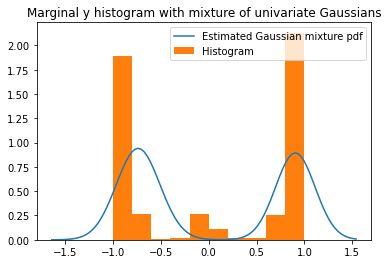

In [42]:
# SAME BUT FOR Y-COORDINATES

model_y = GaussianMixture(n_components=2, n_init=10)
model_y_pred = model_y.fit_predict(np.array(all_y).reshape(-1,1))

weights_y = model_y.weights_.reshape(-1,)
mu_y = model_y.means_.reshape(-1,)
sigma_y = model_y.covariances_.reshape(-1,)
sdevs_y = np.sqrt(sigma_y)

samples_y = []
for i in range(0, 1000):
    if random.uniform(0, 1) < weights_y[0]:
        z = 0
    else:
        z = 1
    samples_y.append(np.random.normal(mu_y[z], sdevs_y[z], 1))

sns.distplot(samples_y, hist=False, label='Estimated Gaussian mixture pdf')

plt.hist(all_y, density=True, label='Histogram')
plt.title('Marginal y histogram with mixture of univariate Gaussians')
plt.legend()


1.905156812134129
-0.42298549056088114 0.20940128280282785


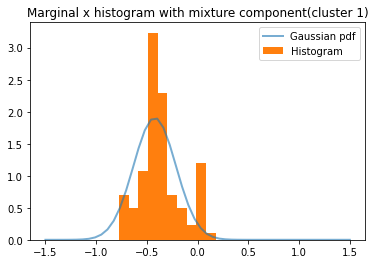

In [33]:
# plotting the histogram of x-coordinates of the FIRST CLASS against the univariate distr
from scipy.stats import norm
# sns.distplot(samples_x, hist=False)
plt.plot(x, norm.pdf(x, loc=mu_x[0], scale=sdevs_x[0]), lw=2, alpha=0.6, label='Gaussian pdf')
plt.hist(x1, density=True, label='Histogram')
plt.title('Marginal x histogram with mixture component(cluster 1)')
plt.legend()
print(1 / (np.sqrt(2 * np.pi) * sdevs_x[0]))
print(mu_x[0], sdevs_x[0])

4.709178034500255
0.9580459812306036 0.08471590529784867


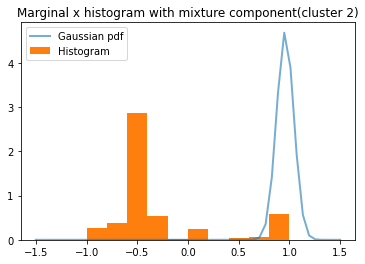

In [43]:
# plotting the x coordinates of the SECOND CLASS against the univariate distr

# sns.distplot(samples_x, hist=False)
plt.plot(x, norm.pdf(x, loc=mu_x[1], scale=sdevs_x[1]), lw=2, alpha=0.6, label='Gaussian pdf')
plt.hist(x2, density=True, label='Histogram')
plt.title('Marginal x histogram with mixture component(cluster 2)')
plt.legend()
print(1 / (np.sqrt(2 * np.pi) * sdevs_x[1]))
print(mu_x[1], sdevs_x[1])

4.904837904104962
0.9046168689972321 0.08133648617980821


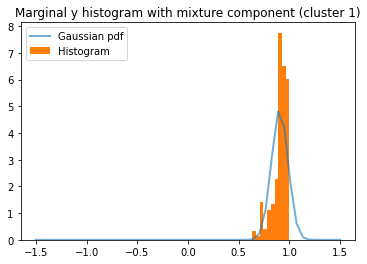

In [44]:
# plotting the Y-COORDINATES of the FIRST CLASS against the univariate distr

# sns.distplot(samples_y, hist=False)
plt.plot(y, norm.pdf(y, loc=mu_y[0], scale=sdevs_y[0]), lw=2, alpha=0.6, label='Gaussian pdf')
plt.hist(y1, density=True, label='Histogram')
plt.title('Marginal y histogram with mixture component (cluster 1)')
plt.legend()
print(1 / (np.sqrt(2 * np.pi) * sdevs_y[0]))
print(mu_y[0], sdevs_y[0])

1.2964913174273995
-0.7393449894180377 0.30770918018413385


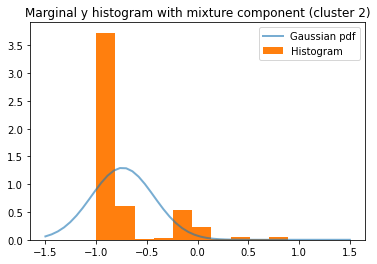

In [45]:
# plotting the Y-COORDINATES of the SECOND CLASS against the univariate distr
plt.plot(y, norm.pdf(y, loc=mu_y[1], scale=sdevs_y[1]), lw=2, alpha=0.6, label='Gaussian pdf')
plt.hist(y2, density=True, label='Histogram')
plt.title('Marginal y histogram with mixture component (cluster 2)')
plt.legend()
print(1 / (np.sqrt(2 * np.pi) * sdevs_y[1]))
print(mu_y[1], sdevs_y[1])

### 4)

Using a bivariate GMM is valid, as the univariate one fails to capture the "natural" clustering of the data. The predicted distribution doesn't exactly conform with the shape of the histograms.

###  5)

Isn't this already done in the contours?

- I think he wants us to do something like colour mixing to show the mixing of responsibilities of each component for each data point.


References:
- [https://matplotlib.org/tutorials/colors/colormap-manipulation.html](https://matplotlib.org/tutorials/colors/colormap-manipulation.html)
- [https://matplotlib.org/tutorials/colors/colormaps.html](https://matplotlib.org/tutorials/colors/colormaps.html)

Text(0.5, 1.0, 'Data labeled with colourmap for component responsibilities')

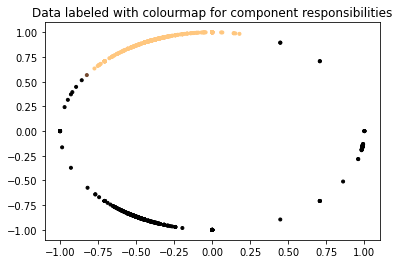

In [160]:
from matplotlib import cm

# get posterior probabilities to be used as input to color_map functions
P_Z = model.predict_proba(data2) 
color_map = cm.get_cmap('copper')
colors = [color_map(x) for x in P_Z[:, 0]]

plt.scatter(data2[:,0], data2[:,1], c=colors, marker='.')
plt.title('Data labeled with colourmap for component responsibilities')

The plot can be interpreted as showing how much mixing of the two Guasssian components occurs for each data point. For the color map we've defined, the black colored points correspond to points where the first component takes a very high responsibility while the light brown colored points correspond to those for the second component. We can observe a brown data point which indicates that the two components do not have as high responsibilities in this case. Said differently, the data point is generated by a stronger mix of the two mixture components than as seen with other points.

# Mandatory Work
### 1)

Text(0.5, 0, 'Angles (radians)')

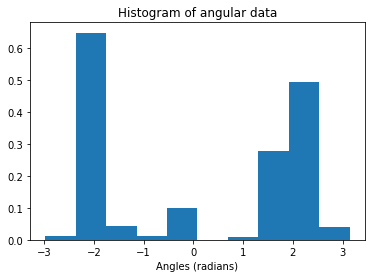

In [59]:
# calculating the angles and plotting their histogram

angles = np.arctan2(data2[:,1], data2[:,0])
plt.hist(angles, density=True)
plt.title('Histogram of angular data')
plt.xlabel('Angles (radians)')

### 2)

Mixture of von-Mises to be defined

### 3)

Answer should be something like: Yes, we have directional data which is more suited to a directional distribution like the von-Mises distribution

### 4)

To be done
References:
- [Clustering on the Unit Hypersphere usingvon Mises-Fisher Distributions](https://www.jmlr.org/papers/volume6/banerjee05a/banerjee05a.pdf)
- [Directional Statistics in Machine Learning: a Brief Review](https://arxiv.org/pdf/1605.00316.pdf)

### 5)

### Fitting a mixture of von Mises distributions

Code in the following sections depends on the library: [spherecluster](https://github.com/jasonlaska/spherecluster)

Installation can be done in two ways as described in the linked repo. If you choose to install from PyPI by `pip install spherecluster`, you might run into an error `ImportError: cannot import name '_k_means' from 'sklearn.cluster'`. To fix this, you have to downgrade your scikit-learn to version 0.22.0 e.g. by running `conda install scikit-learn=0.22.0`.

However, cloning the repository and installing with the develop branch fixes this issue. For more details, see this closed issue [ImportError: cannot import name '\_k\_means' #26](https://github.com/jasonlaska/spherecluster/issues/26)



In [56]:
from spherecluster import VonMisesFisherMixture

movm = VonMisesFisherMixture(n_clusters=2, posterior_type='soft')
movm.fit(test) # note the library expects data in the form of normalized vectors, not angles

print('Estimated parameters',
      '===========================================================',
      f'Means/Positions: {movm.cluster_centers_}',
      f'Concentrations: {movm.concentrations_}',
      f'Weights: {movm.weights_}',
      sep='\n')


/Users/david.emukpere/miniconda3/envs/pytorch-challenge/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)


Estimated parameters
Means/Positions: [[-0.37332788  0.92769946]
 [-0.38271426 -0.92386676]]
Concentrations: [22.05648175  2.71264838]
Weights: [0.47067935 0.52932065]


Text(0.5, 1.0, 'Data labeled according to mixture of von-Mises distributions')

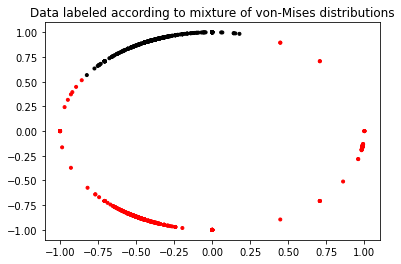

In [61]:
colors = ['r' if label == 1 else 'k' for label in movm.labels_]

plt.scatter(test[:,0], test[:,1], c=colors, marker='.')
plt.title('Data labeled according to mixture of von-Mises distributions')

In [64]:
np.arctan2(movm.cluster_centers_[:, 1], movm.cluster_centers_[:, 0])
# np.arctan2(0.92769946, -0.37332788)

array([ 1.95339001, -1.96352877])

# Optional Question (Von-Mises)


In [ ]:
from numpy import i0
# single von-mises
from scipy.stats import vonmises, vonmises_line

class VonMisesMixture:
    """
    For all things von Mises
    Parameters
    ----------
    n_clusters : int, optional, default: 2
        The number of clusters to form as well as the number of
        centroids to generate.
    weights : None or array [n_clusters, ]
        If None, the algorithm will estimate the weights.
        If an array of weights, algorithm will estimate concentrations and
        centers with given weights.
    max_iter : int, default: 300
        Maximum number of iterations of the estimation algorithm
    tol : float, default: 1e-6
        Relative tolerance to declare convergence
    """
    _init_(self, n_clusters = 2, weights, max_iter, tol):
        if weights:
            self.weights = weights
            
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        
    
    pdf(self, X):
        """
        pdf of VMM
        """
        val = np.sum(weights * self.component_fs.pdf(X))
        return val
    
    sample(self, size=1):
#         coefficients = np.array([0.5, 0.2, 0.3])
#         coefficients /= coefficients.sum()      # in case these did not add up to 1
#         sample_size = 100000

#         num_distr = len(distributions) n_clusters
        data = np.zeros((sample_size, self.n_clusters))
        for idx, vmf in enumerate(self.component_fs):
            data[:, idx] = vmf(size)
        random_idx = np.random.choice(np.arange(self.n_clusters), size=(size,), p=self.weights)
        sample = data[np.arange(size), random_idx]
#         plt.hist(sample, bins=100, density=True)
#         plt.show()
        return sample


        
def simulate_mixture(weights, mus, kappas):
    """
    Simulate a mixture of von-mises
    """
    
    vonmises()
        

